# Import

In [2]:
import pandas as pd
import pandas_gbq
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [3]:
project_id = "rental-price-prediction"
query_landed = """
SELECT * FROM ura_data.landed_data;
"""
query_nonlanded = """
SELECT * FROM ura_data.nonlanded_data;
"""
landed = pandas_gbq.read_gbq(query_landed, project_id=project_id, dialect="standard") # Terrace House, Detached House, Semi-Detached House
nonlanded = pandas_gbq.read_gbq(query_nonlanded, project_id=project_id, dialect="standard") # Non-landed Properties, Executive Condominium

Downloading: 100%|██████████|
Downloading: 100%|██████████|


# One Hot Encoding

In [4]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)
print(landed_encoded.shape)
print(nonlanded_encoded.shape)

(20662, 38)
(237230, 40)


# Run on all features

## Landed

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'district_02', 'district_03', 'district_04', 'district_05', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
'Tuned Hyperparameters:'
{'n_neighbors': 12, 'weights': 'distance'}
training r2: 0.756558776634197
testing r2: 0.584013610337913

score   = 0.584013610337913
r2      = 0.584013610337913
MAE     = 2411.738098219774
RMSE    = 5347.207279573496
MSE     = 28592625.690723788
MAE %   = 0.26717964841123265



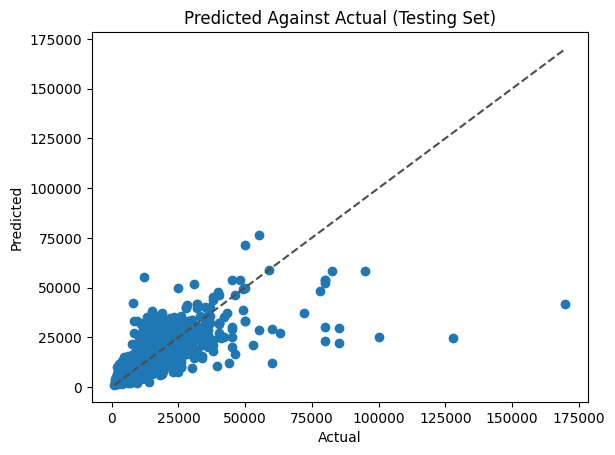

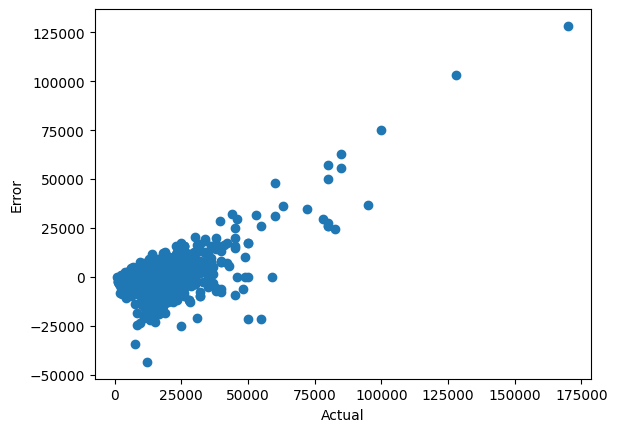

In [5]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

parameters = {
    'n_neighbors': np.arange(1, 15, 1),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
}
cv = GridSearchCV(estimator = KNeighborsRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 10,
                           verbose=0)
cv.fit(X_train_scaled, y_train)

pprint("Tuned Hyperparameters:")
pprint(cv.best_params_)
model = KNeighborsRegressor(n_neighbors=cv.best_params_["n_neighbors"], 
                              weights=cv.best_params_["weights"],
                              metric="euclidean")
model.fit(X_train_scaled, y_train)

print(f"training r2: {model.score(X_train_scaled, y_train)}")
print(f"testing r2: {model.score(X_test_scaled, y_test)}")
pred = model.predict(X_test_scaled)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test_scaled, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()

### Feature Selection (Shapley)

In [6]:
import shap
# Produce the SHAP values
knn_explainer = shap.KernelExplainer(model.predict, shap.sample(X_test_scaled, 50))
knn_shap_values = knn_explainer.shap_values(X_test_scaled.sample(50))

100%|██████████| 50/50 [05:23<00:00,  6.48s/it]


In [7]:
feature_importance = np.abs(knn_shap_values).mean(axis=0)
importances = np.abs(knn_shap_values).mean(axis=0)
feature_names = list(X_train_scaled.columns)

# Create a list of (feature name, importance) tuples
feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=False)
feature_impt_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance")
feature_impt_df

,Feature,Importance
26,district_27,0.000000
4,district_03,0.000000
7,district_07,0.000000
8,district_08,0.000000
12,district_12,0.000000
24,district_25,16.132962
3,district_02,16.344706
23,district_23,26.372659
6,district_05,26.802470
25,district_26,43.477315


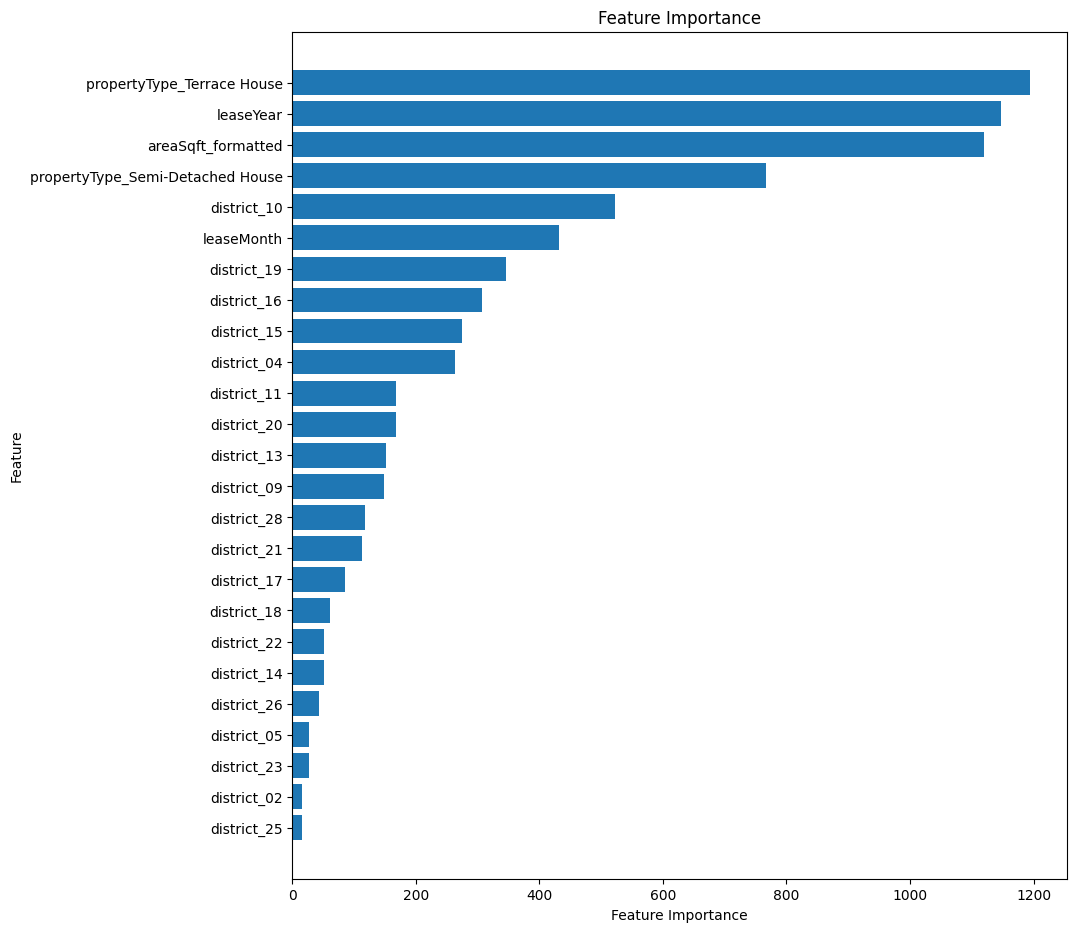

In [8]:
# Plot feature importances
nonzero_feature_importances = feature_impt_df[feature_impt_df["Importance"] != 0]
plt.figure(figsize=(10, 11))
plt.barh(nonzero_feature_importances["Feature"], nonzero_feature_importances["Importance"], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Run on Selected Features

In [9]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

29          propertyType_Terrace House
1                            leaseYear
0                   areaSqft_formatted
28    propertyType_Semi-Detached House
10                         district_10
2                           leaseMonth
19                         district_19
16                         district_16
15                         district_15
5                          district_04
11                         district_11
20                         district_20
13                         district_13
9                          district_09
27                         district_28
21                         district_21
17                         district_17
18                         district_18
22                         district_22
14                         district_14
25                         district_26
6                          district_05
23                         district_23
3                          district_02
24                         district_25
Name: Feature, dtype: obj

{'n_neighbors': 14, 'weights': 'distance'}
training r2: 0.6987371001225234
testing r2: 0.545290212732502

score   = 0.545290212732502
r2      = 0.545290212732502
MAE     = 2703.4272464624105
RMSE    = 5590.5509495003225
MSE     = 31254259.918958962
MAE %   = 0.3055133551849238



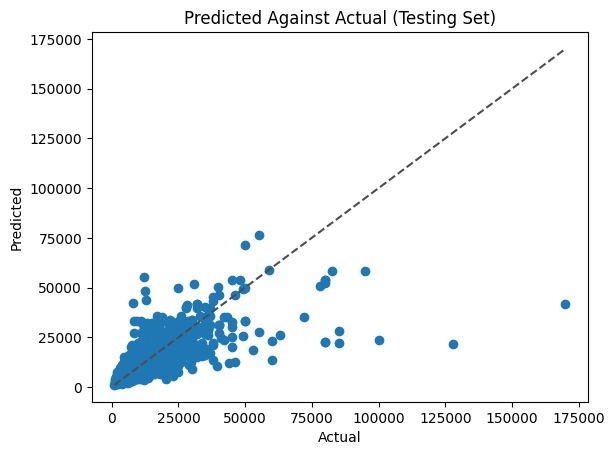

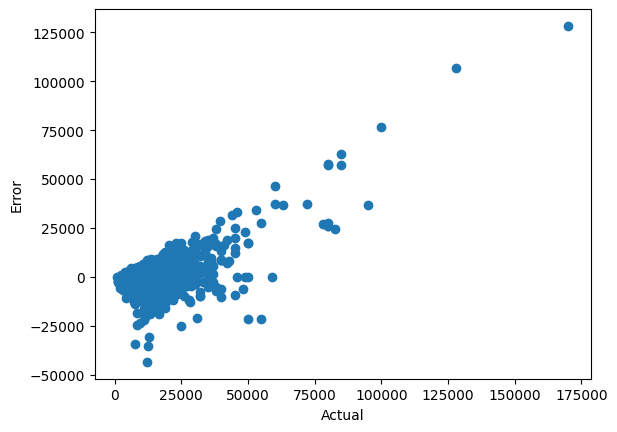

In [10]:
selected_features = [
      "propertyType_Terrace House",
                       "leaseYear",
              "areaSqft_formatted",
"propertyType_Semi-Detached House",
                     "district_10",
                      "leaseMonth",
                     "district_19",
                     "district_16",
                     "district_15",
                     "district_04",]

select_X_train = X_train_scaled[selected_features]
select_X_test = X_test_scaled[selected_features]

# Define the hyperparameters grid for grid search
param_grid = {'n_neighbors': np.arange(2, 15, 1),
            'weights' : ['uniform', 'distance'],}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator = KNeighborsRegressor(),  
                        param_grid = param_grid,
                        scoring = 'neg_mean_absolute_error',
                        cv = 10,
                        verbose=0)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = KNeighborsRegressor(n_neighbors=best_params["n_neighbors"], 
                              weights=best_params["weights"],
                              metric="euclidean")
model.fit(select_X_train, y_train)

print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()

In [11]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

29          propertyType_Terrace House
1                            leaseYear
0                   areaSqft_formatted
28    propertyType_Semi-Detached House
10                         district_10
2                           leaseMonth
19                         district_19
16                         district_16
15                         district_15
5                          district_04
11                         district_11
20                         district_20
13                         district_13
9                          district_09
27                         district_28
21                         district_21
17                         district_17
18                         district_18
22                         district_22
14                         district_14
25                         district_26
6                          district_05
23                         district_23
3                          district_02
24                         district_25
Name: Feature, dtype: obj

## Non-Landed

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'median', 'district_02', 'district_03', 'district_04', 'district_05', 'district_06', 'district_07', 'district_08', 'district_09', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']
'Tuned Hyperparameters:'
{'n_neighbors': 14, 'weights': 'distance'}
training r2: 0.974310883962815
testing r2: 0.8210714733167813

score   = 0.8210714733167813
r2      = 0.8210714733167813
MAE     = 572.9969025995114
RMSE    = 1199.8781326817943
MSE     = 1439707.5332879494
MAE %   = 0.12306872291754986



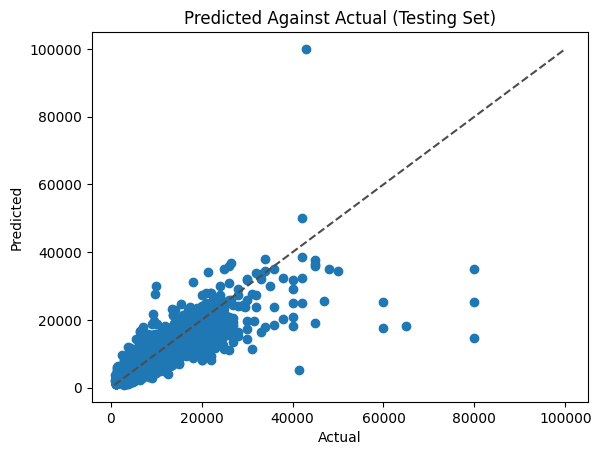

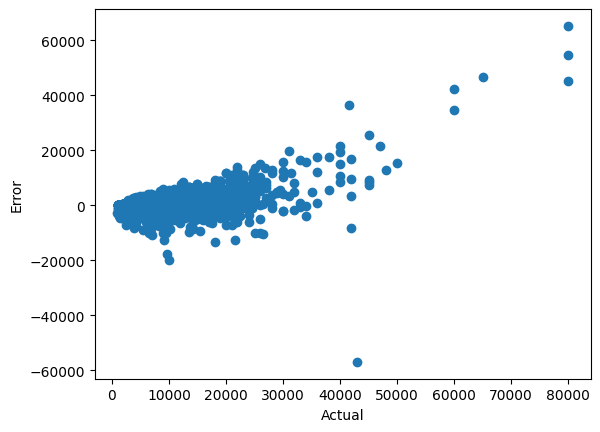

In [13]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter', 'noOfBedRoom']:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], nonlanded_encoded["rent"], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

parameters = {
    'n_neighbors': np.arange(1, 15, 1),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
}
cv = GridSearchCV(estimator = KNeighborsRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 10,
                           verbose=0)
cv.fit(X_train_scaled, y_train)

pprint("Tuned Hyperparameters:")
pprint(cv.best_params_)
model = KNeighborsRegressor(n_neighbors=cv.best_params_["n_neighbors"], 
                              weights=cv.best_params_["weights"],
                              metric="euclidean")
model.fit(X_train_scaled, y_train)

print(f"training r2: {model.score(X_train_scaled, y_train)}")
print(f"testing r2: {model.score(X_test_scaled, y_test)}")
pred = model.predict(X_test_scaled)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test_scaled, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()

### Feature Selection (Shapley)

In [15]:
import shap
# Produce the SHAP values
knn_explainer = shap.KernelExplainer(model.predict, shap.sample(X_test_scaled, 50))
knn_shap_values = knn_explainer.shap_values(X_test_scaled.sample(50))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [53:15<00:00, 63.91s/it] 


In [16]:
feature_importance = np.abs(knn_shap_values).mean(axis=0)
importances = np.abs(knn_shap_values).mean(axis=0)
feature_names = list(X_train_scaled.columns)

# Create a list of (feature name, importance) tuples
feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=False)
feature_impt_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance")
feature_impt_df

,Feature,Importance
30,propertyType_Non-landed Properties,0.000000
27,district_26,0.000000
13,district_11,0.000000
8,district_06,0.000000
9,district_07,11.024601
5,district_03,12.358864
4,district_02,13.279572
26,district_25,13.885242
6,district_04,16.041296
15,district_13,16.926636


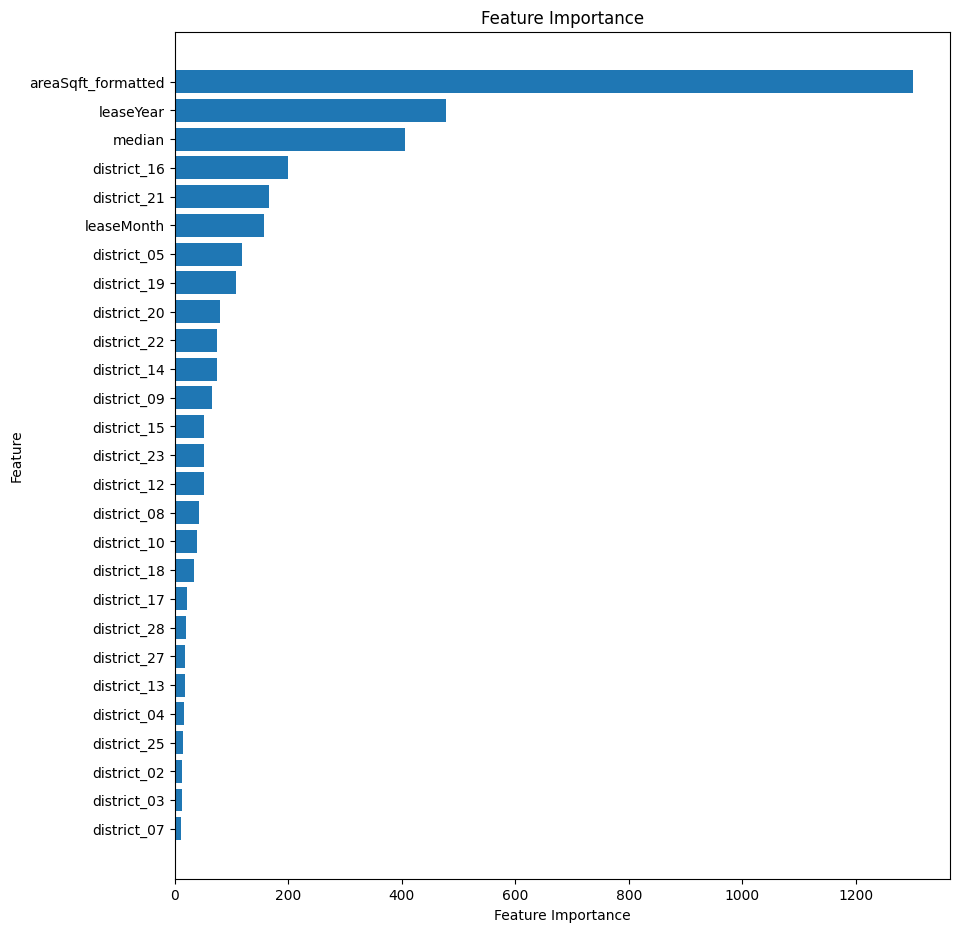

In [17]:
# Plot feature importances
nonzero_feature_importances = feature_impt_df[feature_impt_df["Importance"] != 0]
plt.figure(figsize=(10, 11))
plt.barh(nonzero_feature_importances["Feature"], nonzero_feature_importances["Importance"], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Run on Selected Features

In [18]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

0     areaSqft_formatted
1              leaseYear
3                 median
18           district_16
23           district_21
2             leaseMonth
7            district_05
21           district_19
22           district_20
24           district_22
16           district_14
11           district_09
17           district_15
25           district_23
14           district_12
10           district_08
12           district_10
20           district_18
19           district_17
29           district_28
28           district_27
15           district_13
6            district_04
26           district_25
4            district_02
5            district_03
9            district_07
Name: Feature, dtype: object

{'n_neighbors': 14, 'weights': 'distance'}
training r2: 0.9641209651791036
testing r2: 0.8035104553960961

score   = 0.8035104553960961
r2      = 0.8035104553960961
MAE     = 587.5139811564768
RMSE    = 1257.3815069783996
MSE     = 1581008.2540912712
MAE %   = 0.12665782465921177



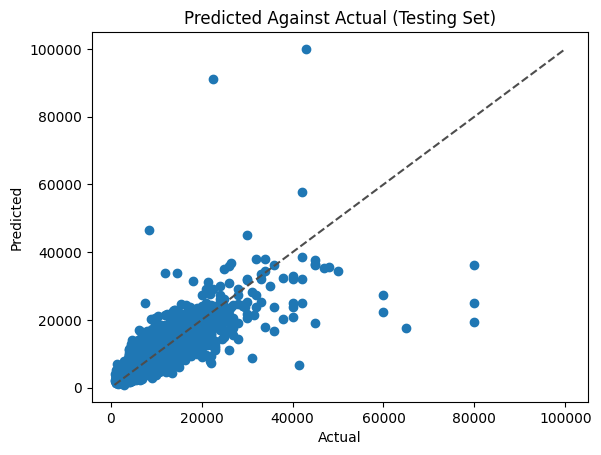

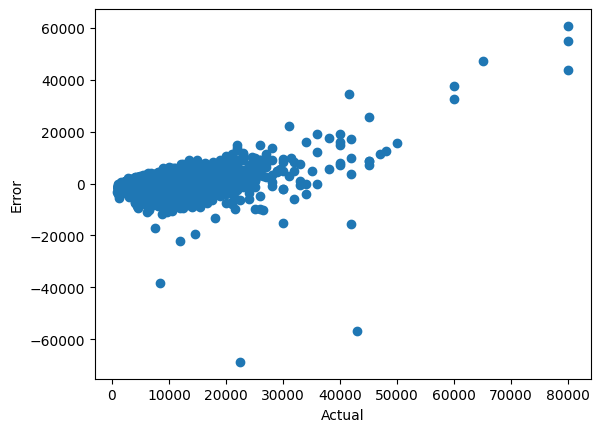

In [19]:
selected_features = [
"areaSqft_formatted",
         "leaseYear",
            "median",
       "district_16",
       "district_21",
        "leaseMonth",
       "district_05",
       "district_19",]

select_X_train = X_train_scaled[selected_features]
select_X_test = X_test_scaled[selected_features]

# Define the hyperparameters grid for grid search
param_grid = {'n_neighbors': np.arange(2, 15, 1),
            'weights' : ['uniform', 'distance'],}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator = KNeighborsRegressor(),  
                        param_grid = param_grid,
                        scoring = 'neg_mean_absolute_error',
                        cv = 10,
                        verbose=0)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = KNeighborsRegressor(n_neighbors=best_params["n_neighbors"], 
                              weights=best_params["weights"],
                              metric="euclidean")
model.fit(select_X_train, y_train)

print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()